In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.layers import Input, Conv1D, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
import matplotlib as mpl

# Code


In [3]:
# Constants
FILE_PATHS = ['t_data.csv', 't_label.csv', 'v_data.csv', 'v_label.csv']

x_train = pd.read_csv(FILE_PATHS[0])
y_train = pd.read_csv(FILE_PATHS[1])
x_test = pd.read_csv(FILE_PATHS[2])
y_test = pd.read_csv(FILE_PATHS[3])

y_train = keras.utils.to_categorical(y_train, num_classes=3)
y_test = keras.utils.to_categorical(y_test, num_classes=3)

x_train, y_train = shuffle(x_train, y_train, random_state=5)
#x_test, y_test = shuffle(x_test, y_test, random_state=5)

# assemble initial data
n_initial = 30
initial_idx = np.random.choice(range(len(x_train)),
                               size=n_initial,
                               replace=False)
x_initial = x_train.iloc[initial_idx]
y_initial = y_train[initial_idx]
x_initial = x_initial.to_numpy()

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [4]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(x_train.shape[1], 1)))
    model.add(
        Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(80, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# create the classifier
classifier = KerasClassifier(create_model,
                             optimizer='adam',
                             loss='categorical_crossentropy',
                             metrics=['accuracy'],
                             epochs=10,
                             batch_size=10,
                             verbose=0,
                             validation_split=0.3,
                             shuffle=True)

In [5]:
# initialize ActiveLearner
learner = ActiveLearner(estimator=classifier,
                        X_training=x_initial,
                        y_training=y_initial,
                        verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - accuracy: 0.3179 - loss: 90.8253 - val_accuracy: 0.5556 - val_loss: 24.6401
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2679 - loss: 20.6056 - val_accuracy: 0.1111 - val_loss: 4.0492
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3280 - loss: 9.7397 - val_accuracy: 0.6667 - val_loss: 4.0541
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.5607 - loss: 8.8226 - val_accuracy: 0.5556 - val_loss: 2.4786
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4018 - loss: 4.0720 - val_accuracy: 0.1111 - val_loss: 1.3726
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2202 - loss: 3.0297 - val_accuracy: 0.4444 - val_loss: 1.0903
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3893 - loss: 1.0963 - val_accuracy: 0.2222 - val_loss: 1.1182
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4869 - loss: 1.2322 - val_accuracy: 0.3333 - val_lo

In [6]:
unqueried_score = learner.score(x_test,y_test)
print(unqueried_score)
performance_history = [unqueried_score]
current_epochs = 10
current_batch_size=10

0.38666666666666666


In [ ]:
# the active learning loop
n_queries = 30

for idx in range(n_queries):
    print('Query no. %d' % (idx + 1))
    query_idx, query_instance = learner.query(x_pool,
                                              n_instances=30
                                            )

    queried_x = x_pool[query_idx]
    queried_y = y_pool[query_idx]
    learner.teach(X=queried_x, y=queried_y,verbose=1,epochs=current_epochs, batch_size=current_batch_size)
    # remove queried instance from pool
    x_pool = np.delete(x_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

    
    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(x_test,y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=idx + 1,
                                                        acc=model_accuracy))

    print(x_pool.shape)
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
    # Increment the number of epochs for the next query
    current_epochs += 1
    current_batch_size+=1

Query no. 1
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - accuracy: 0.3621 - loss: 97.6031 - val_accuracy: 0.0000e+00 - val_loss: 57.4998
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.2976 - loss: 34.2426 - val_accuracy: 0.5000 - val_loss: 1.0418
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.2387 - loss: 7.6311 - val_accuracy: 0.5000 - val_loss: 1.6563
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.3994 - loss: 3.5690 - val_accuracy: 0.5556 - val_loss: 1.0891
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.3873 - loss: 1.1934 - val_accuracy: 0.0000e+00 - val_loss: 1.1085
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.4823 - loss: 1.0154 - val_accuracy: 0.0000e+00 - val_loss: 1.1081
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.3776 - loss: 1.0517 - val_accuracy: 0.0000e+00 - val_loss: 1.1087
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.4012 - loss: 1.0129 - v

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.3463 - loss: 1.0427 - val_accuracy: 0.8364 - val_loss: 1.0711
Epoch 5/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4035 - loss: 1.0011 - val_accuracy: 0.8545 - val_loss: 1.0633
Epoch 6/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.4716 - loss: 0.9238 - val_accuracy: 0.8364 - val_loss: 1.0483
Epoch 7/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6647 - loss: 0.7864 - val_accuracy: 0.8364 - val_loss: 1.0024
Epoch 8/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8867 - loss: 0.6147 - val_accuracy: 0.8182 - val_loss: 0.9853
Epoch 9/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9028 - loss: 0.3716 - val_accuracy: 0.7818 - val_loss: 0.8962
Epoch 10/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9106 - loss: 0.2469 - val_accuracy: 0.8545 - val_loss: 0.5985
Epoch 11/14
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.9711 - loss: 0.0926 - val_accuracy: 0.7273 - val_loss: 0.7017
E

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.6950 - loss: 0.7704 - val_accuracy: 0.4074 - val_loss: 1.5681
Epoch 9/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8743 - loss: 0.3994 - val_accuracy: 0.2222 - val_loss: 2.3044
Epoch 10/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9576 - loss: 0.1024 - val_accuracy: 0.2469 - val_loss: 2.9517
Epoch 11/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9734 - loss: 0.0490 - val_accuracy: 0.3827 - val_loss: 2.0889
Epoch 12/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9904 - loss: 0.0455 - val_accuracy: 0.4074 - val_loss: 2.2331
Epoch 13/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 0.3580 - val_loss: 2.8787
Epoch 14/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9978 - loss: 0.0096 - val_accuracy: 0.4198 - val_loss: 2.4614
Epoch 15/17
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.4691 

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.3930 - loss: 1.0966 - val_accuracy: 0.1743 - val_loss: 1.1081
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.4878 - loss: 1.0854 - val_accuracy: 0.1743 - val_loss: 1.1092
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.4346 - loss: 1.0702 - val_accuracy: 0.4954 - val_loss: 1.0621
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.3829 - loss: 0.9751 - val_accuracy: 0.4495 - val_loss: 1.0538
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.5452 - loss: 0.8718 - val_accuracy: 0.3670 - val_loss: 1.1453
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.7734 - loss: 0.6338 - val_accuracy: 0.5138 - val_loss: 1.0746
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9106 - loss: 0.3654 - val_accuracy: 0.4404 - val_loss: 1.3369
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9189 - loss: 0.2246 - val_accuracy: 0.5229 - val

Epoch 12/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9764 - loss: 0.0720 - val_accuracy: 0.7619 - val_loss: 0.8044
Epoch 13/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.9848 - loss: 0.0303 - val_accuracy: 0.6984 - val_loss: 0.9801
Epoch 14/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9855 - loss: 0.0430 - val_accuracy: 0.7460 - val_loss: 0.9439
Epoch 15/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9947 - loss: 0.0213 - val_accuracy: 0.7143 - val_loss: 1.0511
Epoch 16/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.9845 - loss: 0.0381 - val_accuracy: 0.6508 - val_loss: 1.1716
Epoch 17/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9962 - loss: 0.0177 - val_accuracy: 0.7143 - val_loss: 0.9843
Epoch 18/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9991 - loss: 0.0053 - val_accuracy: 0.6905 - val_loss: 1.1144
Epoch 19/22
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 1.0000 - loss: 0.0051 - val_accu

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9876 - loss: 0.0477 - val_accuracy: 0.6597 - val_loss: 1.1872
Epoch 17/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.6736 - val_loss: 1.4600
Epoch 18/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9890 - loss: 0.0443 - val_accuracy: 0.6319 - val_loss: 1.2381
Epoch 19/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9974 - loss: 0.0093 - val_accuracy: 0.6528 - val_loss: 1.2227
Epoch 20/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9975 - loss: 0.0197 - val_accuracy: 0.6389 - val_loss: 1.2590
Epoch 21/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.9983 - loss: 0.0145 - val_accuracy: 0.6806 - val_loss: 1.2687
Epoch 22/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.9945 - loss: 0.0166 - val_accuracy: 0.6597 - val_loss: 1.2169
Epoch 23/24
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.9963 - loss: 0.0151 - val_accuracy: 0.6944

15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9929 - loss: 0.0254 - val_accuracy: 0.6667 - val_loss: 1.5892
Epoch 17/26
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.9919 - loss: 0.0190 - val_accuracy: 0.6296 - val_loss: 1.5976
Epoch 18/26
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9997 - loss: 0.0085 - val_accuracy: 0.6358 - val_loss: 1.6211
Epoch 19/26
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9804 - loss: 0.0380 - val_accuracy: 0.6667 - val_loss: 1.4819
Epoch 20/26
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9970 - loss: 0.0189 - val_accuracy: 0.6173 - val_loss: 1.8168
Epoch 21/26
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9963 - loss: 0.0060 - val_accuracy: 0.6420 - val_loss: 1.8941
Epoch 22/26
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.9899 - loss: 0.0183 - val_accuracy: 0.6420 - val_loss: 1.7688
Epoch 23/26
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.6420

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9907 - loss: 0.0513 - val_accuracy: 0.5222 - val_loss: 1.3728
Epoch 13/28
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.9918 - loss: 0.0368 - val_accuracy: 0.5278 - val_loss: 1.6300
Epoch 14/28
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9899 - loss: 0.0485 - val_accuracy: 0.5500 - val_loss: 1.4664
Epoch 15/28
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 1.0000 - loss: 0.0107 - val_accuracy: 0.5500 - val_loss: 1.5036
Epoch 16/28
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9929 - loss: 0.0153 - val_accuracy: 0.5778 - val_loss: 1.4397
Epoch 17/28
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9982 - loss: 0.0163 - val_accuracy: 0.5944 - val_loss: 1.7908
Epoch 18/28
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.9762 - loss: 0.0546 - val_accuracy: 0.5722 - val_loss: 1.4996
Epoch 19/28
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.9948 - loss: 0.0235 - val_accuracy: 0.5500

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.4010 - loss: 1.0735 - val_accuracy: 0.4271 - val_loss: 1.0523
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.4229 - loss: 1.0371 - val_accuracy: 0.5779 - val_loss: 0.9496
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.4086 - loss: 0.9999 - val_accuracy: 0.5276 - val_loss: 1.0189
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.4780 - loss: 0.9434 - val_accuracy: 0.5327 - val_loss: 0.8162
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.7572 - loss: 0.6271 - val_accuracy: 0.5126 - val_loss: 0.7635
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.8043 - loss: 0.4033 - val_accuracy: 0.4975 - val_loss: 1.3435
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.8634 - loss: 0.3257 - val_accuracy: 0.5327 - val_loss: 0.8394
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.9261 - loss: 0.2345 - val_accuracy: 0.5829 - va

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.9984 - loss: 0.0050 - val_accuracy: 0.9615 - val_loss: 0.1128
Epoch 25/31
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 1.0000 - loss: 0.0059 - val_accuracy: 0.9519 - val_loss: 0.1334
Epoch 26/31
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.9984 - loss: 0.0059 - val_accuracy: 0.9279 - val_loss: 0.2237
Epoch 27/31
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9856 - val_loss: 0.0312
Epoch 28/31
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 1.0000 - loss: 8.0662e-04 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 29/31
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 1.0000 - loss: 1.2515e-04 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 30/31
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 1.0000 - loss: 1.3542e-04 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 31/31
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 1.0000 - loss: 1.4096e-04 - val_

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.8655 - loss: 0.3631 - val_accuracy: 0.6444 - val_loss: 0.8670
Epoch 11/33
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.9525 - loss: 0.1315 - val_accuracy: 0.6756 - val_loss: 0.8048
Epoch 12/33
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.9580 - loss: 0.1171 - val_accuracy: 0.7244 - val_loss: 0.7341
Epoch 13/33
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.9674 - loss: 0.0725 - val_accuracy: 0.7422 - val_loss: 0.7403
Epoch 14/33
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.9698 - loss: 0.0892 - val_accuracy: 0.7067 - val_loss: 0.7996
Epoch 15/33
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9980 - loss: 0.0318 - val_accuracy: 0.6844 - val_loss: 0.9622
Epoch 16/33
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.9760 - loss: 0.0401 - val_accuracy: 0.7156 - val_loss: 0.8467
Epoch 17/33
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.9888 - loss: 0.0243 - val_accuracy: 0.7289

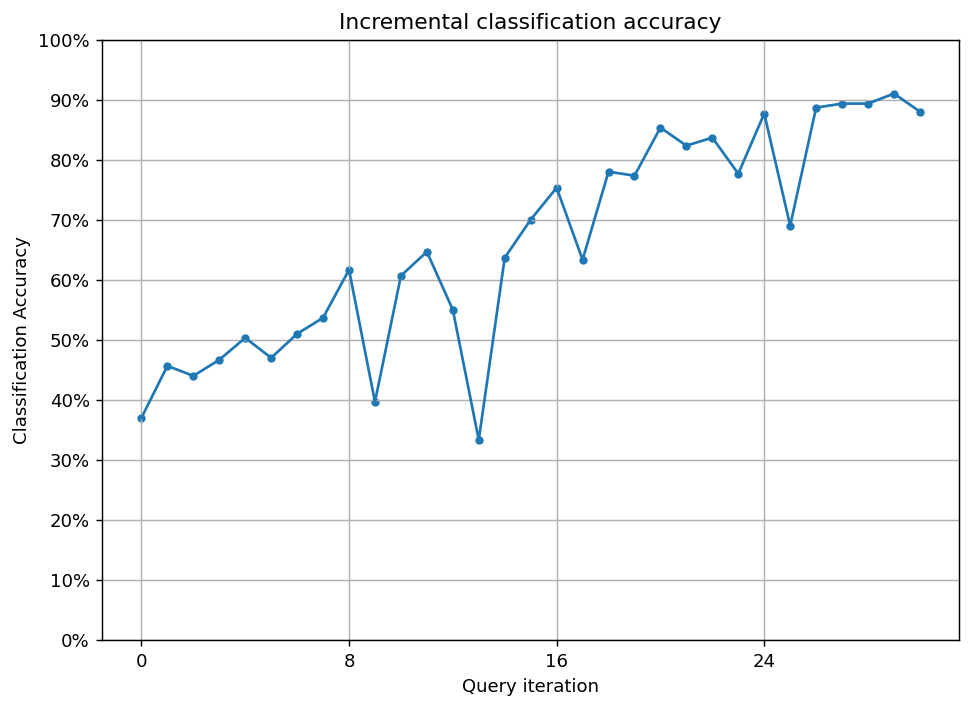

In [154]:
from matplotlib.widgets import Cursor
# Plot our performance over time.
fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

ax.plot(performance_history)
ax.scatter(range(len(performance_history)), performance_history, s=13)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')
cursor = Cursor(ax, useblit=True, color='red', linewidth=2)
plt.show()

In [155]:
learner.score(x_test,y_test)

0.88